In [6]:
import numpy as np
import matplotlib.pyplot as plt
from transforms3d.euler import mat2euler
from tqdm import tqdm
import transforms3d
from scipy import linalg
from scipy.sparse import lil_matrix, block_diag



In [21]:
# Utils Functions

def load_data(file_name: str):
    '''
    function to read visual features, IMU measurements, and calibration parameters
    Input:
        file_name: the input data file. Should look like "XX.npy"
    Output:
        linear_velocity: velocity measurements in IMU frame
            with shape t*3
        angular_velocity: angular velocity measurements in IMU frame
            with shape t*3
        features: visual feature point coordinates in stereo images, 
            with shape 4*n*t, where n is number of features
        t: time stamp
            with shape t*1
        K_l: leftcamera intrinsic matrix
            with shape 3*3
        K_r: right camera intrinsic matrix
            with shape 3*3
        extL_T_imu: extrinsic transformation from imu frame to left camera, in SE(3).
            with shape 4*4
        extL_T_imu: extrinsic transformation from imu frame to right camera, in SE(3).
            with shape 4*4
    '''
    data = np.load(file_name, allow_pickle = True).item()
    v_t = data["v_t"] # linear velocities
    w_t = data["w_t"] # angular velocities
    timestamps = data["timestamps"] # UNIX timestamps
    features = data["features"] # 4 x num_features x t : pixel coordinates of the visual features
    K_l = data["K_l"] # intrinsic calibration matrix of left camera
    K_r = data["K_r"] # intrinsic calibration matrix of right camera
    extL_T_imu = data["extL_T_imu"] # transformation from imu frame to left camera frame
    extR_T_imu = data["extR_T_imu"] # transformation from imu frame to right camera frame
    
    return v_t,w_t,timestamps,features,K_l,K_r,extL_T_imu,extR_T_imu


def visualize_trajectory_2d(pose,landmarks , path_name="Unknown",show_ori=False):
    '''
    function to visualize the trajectory in 2D
    Input:
        pose:   4*4*N matrix representing the camera pose, 
                where N is the number of poses, and each
                4*4 matrix is in SE(3)
    '''
    fig,ax = plt.subplots(figsize=(5,5))
    n_pose = pose.shape[0]
    ax.plot(pose[:,0,3],pose[:,1,3],'r-',label=path_name)
    ax.scatter(pose[0,0,3],pose[0,1,3],marker='s',label="start")
    ax.scatter(pose[-1,0,3],pose[-1,1,3],marker='o',label="end")
    ax.scatter(landmarks[:,0], landmarks[:, 1], s=5, c='k', marker='x')
  
    if show_ori:
        select_ori_index = list(range(0,n_pose,max(int(n_pose/50), 1)))
        yaw_list = []
        
        for i in select_ori_index:
            _,_,yaw = mat2euler(pose[i,:3,:3])
            yaw_list.append(yaw)
    
        dx = np.cos(yaw_list)
        dy = np.sin(yaw_list)
        dx,dy = [dx,dy]/np.sqrt(dx**2+dy**2)
        ax.quiver(pose[select_ori_index,0,3],pose[select_ori_index,1,3],dx,dy,\
            color="b",units="xy",width=1, headlength=0.002,headaxislength=0.001)
            
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.axis('equal')
    ax.grid(False)
    ax.legend()

    return fig, ax




def projection(ph):
  '''
  ph = n x 4 = homogeneous point coordinates
  r = n x 4 = ph/ph[...,2] = normalized z axis coordinates
  '''  
  return ph/ph[...,2,None]
  
def projectionJacobian(ph):
  '''
  ph = n x 4 = homogeneous point coordinates
  J = n x 4 x 4 = Jacobian of ph/ph[...,2]
  '''  
  J = np.zeros(ph.shape+(4,))
  iph2 = 1.0/ph[...,2]
  ph2ph2 = ph[...,2]**2
  J[...,0,0], J[...,1,1],J[...,3,3] = iph2,iph2,iph2
  J[...,0,2] = -ph[...,0]/ph2ph2
  J[...,1,2] = -ph[...,1]/ph2ph2
  J[...,3,2] = -ph[...,3]/ph2ph2
  return J


def inversePose(T):
  '''
  @Input:
    T = n x 4 x 4 = n elements of SE(3)
  @Output:
    iT = n x 4 x 4 = inverse of T
  '''
  iT = np.empty_like(T)
  iT[...,0,0], iT[...,0,1], iT[...,0,2] = T[...,0,0], T[...,1,0], T[...,2,0] 
  iT[...,1,0], iT[...,1,1], iT[...,1,2] = T[...,0,1], T[...,1,1], T[...,2,1] 
  iT[...,2,0], iT[...,2,1], iT[...,2,2] = T[...,0,2], T[...,1,2], T[...,2,2]
  iT[...,:3,3] = -np.squeeze(iT[...,:3,:3] @ T[...,:3,3,None])
  iT[...,3,:] = T[...,3,:]
  return iT


def axangle2skew(a):
  '''
  converts an n x 3 axis-angle to an n x 3 x 3 skew symmetric matrix 
  '''
  S = np.empty(a.shape[:-1]+(3,3))
  S[...,0,0].fill(0)
  S[...,0,1] =-a[...,2]
  S[...,0,2] = a[...,1]
  S[...,1,0] = a[...,2]
  S[...,1,1].fill(0)
  S[...,1,2] =-a[...,0]
  S[...,2,0] =-a[...,1]
  S[...,2,1] = a[...,0]
  S[...,2,2].fill(0)
  return S

def axangle2twist(x):
  '''
  @Input:
    x = n x 6 = n elements of position and axis-angle
  @Output:
    T = n x 4 x 4 = n elements of se(3)
  '''
  T = np.zeros(x.shape[:-1]+(4,4))
  T[...,0,1] =-x[...,5]
  T[...,0,2] = x[...,4]
  T[...,0,3] = x[...,0]
  T[...,1,0] = x[...,5]
  T[...,1,2] =-x[...,3]
  T[...,1,3] = x[...,1]
  T[...,2,0] =-x[...,4]
  T[...,2,1] = x[...,3]
  T[...,2,3] = x[...,2]
  return T

def twist2axangle(T):
  '''
  converts an n x 4 x 4 twist (se3) matrix to an n x 6 axis-angle 
  '''
  return T[...,[0,1,2,2,0,1],[3,3,3,1,2,0]]

def axangle2adtwist(x):
  '''
  @Input:
    x = n x 6 = n elements of position and axis-angle
  @Output:
    A = n x 6 x 6 = n elements of ad(se(3))
  '''
  A = np.zeros(x.shape+(6,))
  A[...,0,1] =-x[...,5]
  A[...,0,2] = x[...,4]
  A[...,0,4] =-x[...,2]
  A[...,0,5] = x[...,1]
  
  A[...,1,0] = x[...,5]
  A[...,1,2] =-x[...,3]
  A[...,1,3] = x[...,2]
  A[...,1,5] =-x[...,0]
  
  A[...,2,0] =-x[...,4]
  A[...,2,1] = x[...,3]
  A[...,2,3] =-x[...,1]
  A[...,2,4] = x[...,0]
  
  A[...,3,4] =-x[...,5] 
  A[...,3,5] = x[...,4] 
  A[...,4,3] = x[...,5]
  A[...,4,5] =-x[...,3]   
  A[...,5,3] =-x[...,4]
  A[...,5,4] = x[...,3]
  return A

def twist2pose(T):
  '''
  converts an n x 4 x 4 twist (se3) matrix to an n x 4 x 4 pose (SE3) matrix 
  '''
  rotang = np.sqrt(np.sum(T[...,[2,0,1],[1,2,0]]**2,axis=-1)[...,None,None]) # n x 1
  Tn = np.nan_to_num(T / rotang)
  Tn2 = Tn@Tn
  Tn3 = Tn@Tn2
  eye = np.zeros_like(T)
  eye[...,[0,1,2,3],[0,1,2,3]] = 1.0
  return eye + T + (1.0 - np.cos(rotang))*Tn2 + (rotang - np.sin(rotang))*Tn3
  
def axangle2pose(x):
  '''
  @Input:
    x = n x 6 = n elements of position and axis-angle
  @Output:
    T = n x 4 x 4 = n elements of SE(3)
  '''
  return twist2pose(axangle2twist(x))


def pose2adpose(T):
  '''
  converts an n x 4 x 4 pose (SE3) matrix to an n x 6 x 6 adjoint pose (ad(SE3)) matrix 
  '''
  calT = np.empty(T.shape[:-2]+(6,6))
  calT[...,:3,:3] = T[...,:3,:3]
  calT[...,:3,3:] = axangle2skew(T[...,:3,3]) @ T[...,:3,:3]
  calT[...,3:,:3] = np.zeros(T.shape[:-2]+(3,3))
  calT[...,3:,3:] = T[...,:3,:3]
  return calT



In [32]:
 # Load the measurements
filename = "data/dataset00/dataset00.npy"
v_t,w_t,timestamps,features,K_l,K_r,extL_T_imu,extR_T_imu = load_data(filename)

print("v_t shape:", np.shape(v_t))
print("w_t shape:", np.shape(w_t))
print("timestamps shape:", np.shape(timestamps))
print("features shape:", np.shape(features))
print("K_l shape:", np.shape(K_l))
print("K_r shape:", np.shape(K_r))
print("extL_T_imu shape:", np.shape(extL_T_imu))
print("extR_T_imu shape:", np.shape(extR_T_imu))
print (features.shape[1])
print (K_l,K_r)


v_t shape: (3755, 3)
w_t shape: (3755, 3)
timestamps shape: (3755,)
features shape: (4, 5376, 3755)
K_l shape: (3, 3)
K_r shape: (3, 3)
extL_T_imu shape: (4, 4)
extR_T_imu shape: (4, 4)
5376
[[377.22922083   0.         326.35186498]
 [  0.         377.48656584 239.65966536]
 [  0.           0.           1.        ]] [[377.53525716   0.         328.19337129]
 [  0.         377.20984138 240.42687894]
 [  0.           0.           1.        ]]


In [33]:

# Downsample features to reduce computational load
def downsample_features(features, step=5):
    """Keep every nth feature to reduce computation"""
    return features[:, ::step, :]
dfeatures = downsample_features(features)
num_features = dfeatures.shape[1]
num_timesteps = dfeatures.shape[2]
print (num_timesteps,num_features)
num_features = features.shape[1]
# Initialize landmarks 
mu = np.full((num_features, 3), np.nan)

3755 1076


100%|██████████| 3754/3754 [00:00<00:00, 24669.98it/s]


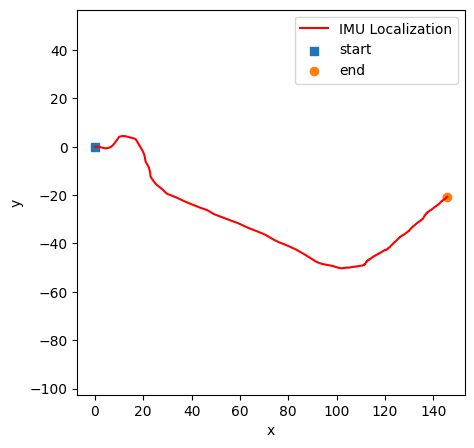

In [34]:
def imu_localization_ekf_prediction(v_t, w_t, timestamps):
    """
    IMU Localization via EKF Prediction
    Input:
        v_t: linear velocity measurements in IMU frame (shape: t x 3)
        w_t: angular velocity measurements in IMU frame (shape: t x 3)
        timestamps: time stamps (shape: t)
    Output:
        poses: estimated poses over time (shape: t x 4 x 4)
        covariances: covariance matrices over time (shape: t x 6 x 6)
    """
    num_timesteps = len(timestamps)
    poses = np.zeros((num_timesteps, 4, 4))  # SE(3) poses
    covariances = np.zeros((num_timesteps, 6, 6))  # Covariance matrices

    # Initial pose (identity matrix)
    poses[0] = np.eye(4)
    # Initial covariance (small initial uncertainty)
    covariances[0] = np.eye(6) * 1e-4

    # Process noise covariance (tune this based on IMU noise characteristics)
    Q = np.eye(6) * 1e-4

    for t in tqdm(range(1, num_timesteps)):
        dt = timestamps[t] - timestamps[t - 1]  # Time difference

        # Current pose and covariance
        T_prev = poses[t - 1]
        P_prev = covariances[t - 1]

        # IMU measurements (linear and angular velocity)
        v = v_t[t - 1]
        w = w_t[t - 1]

        # SE(3) kinematics: T_{t+1} = T_t * exp(dt * twist)
        twist = np.zeros((4, 4))
        twist[:3, :3] = axangle2skew(w)  # Angular velocity (skew-symmetric matrix)
        twist[:3, 3] = v  # Linear velocity
        T_next = T_prev @ linalg.expm(twist * dt)

        # Jacobian of the motion model (F_t)
        F_t = np.eye(6)  # Simplified Jacobian (identity for small dt)
        F_t[:3, 3:] = axangle2skew(v) * dt  # Update for linear velocity

        # Covariance prediction: P_{t+1} = F_t P_t F_t^T + Q
        P_next = F_t @ P_prev @ F_t.T + Q

        # Store the next pose and covariance
        poses[t] = T_next
        covariances[t] = P_next

    return poses, covariances

# Run IMU localization
poses, covariances = imu_localization_ekf_prediction(v_t, w_t, timestamps)

# Visualize the trajectory
visualize_trajectory_2d(poses, mu,path_name="IMU Localization", show_ori=False)
plt.show()

In [35]:

def stereo_triangulation(z0, K_l, b, extL_T_imu, pose):
    """Compute 3D position from single stereo pair observation"""
    # Extract parameters from calibration matrices
    f_u = K_l[0, 0]
    c_u = K_l[0, 2]
    c_v = K_l[1, 2]

    # Get pixel coordinates
    ul, vl = z0[0], z0[1]
    ur, vr = z0[2], z0[3]
    d = ul - ur

    # Calculate depth using stereo geometry
    Z = (f_u * b) / d

    # Calculate world coordinates in the left camera frame
    X = Z * (ul - c_u) / f_u
    Y = Z * (vl - c_v) / f_u  # Using f_u for consistency

    # Transform to world frame
    point_cam = np.array([X, Y, Z, 1])
    #point_world = pose @ np.linalg.inv(extL_T_imu) @ point_cam
    point_world = pose @ extL_T_imu @ point_cam
    return point_world[:3]

def landmark_mapping_ekf_update(poses, features, K_l, K_r, extL_T_imu, extR_T_imu,
                               process_noise=1e-4, obs_noise=1e-2):
    """EKF-based landmark mapping with sparse covariance and outlier removal"""
    # Compute stereo baseline from extrinsic calibration
    b = np.linalg.norm(extR_T_imu[:3, 3] - extL_T_imu[:3, 3])
    
    num_features = features.shape[1]
    num_timesteps = features.shape[2]
    
    # Initialize landmarks and covariance
    mu = np.full((num_features, 3), np.nan)  # Mean estimates
    cov = lil_matrix(block_diag([np.eye(3) * process_noise for _ in range(num_features)]))  # Sparse covariance
    valid_features = set()  # Track valid features

    # Observation noise matrix
    R = np.eye(4) * obs_noise

    # Main EKF loop
    for t in tqdm(range(num_timesteps)):
        T = poses[t]  # Current IMU pose

        # Get visible features at this timestep
        visible = [j for j in range(num_features) if not np.all(features[:, j, t] == -1)]

        for j in visible:
            z = features[:, j, t]  # Current observation [ul, vl, ur, vr]

            if j not in valid_features:
                # Initialize landmark using stereo triangulation
                mu[j] = stereo_triangulation(z, K_l, b, extL_T_imu, T)
                valid_features.add(j)
            else:
                # Update existing landmark using EKF
                m = mu[j]  # Current landmark estimate
                m_hom = np.append(m, 1)  # Homogeneous coordinates

                # Left camera projection
                cam_left = extL_T_imu @ np.linalg.inv(T) @ m_hom
                z_left = K_l @ (cam_left[:3] / cam_left[2])

                # Right camera projection
                cam_right = extR_T_imu @ np.linalg.inv(T) @ m_hom
                z_right = K_r @ (cam_right[:3] / cam_right[2])

                # Predicted observation [ul, vl, ur, vr]
                z_pred = np.concatenate([z_left[:2], z_right[:2]])

                # Compute Jacobian
                J_left = (K_l[:2, :3] @  # Use full intrinsic matrix (2x3)
                          np.linalg.inv(T)[:3, :3] @  # Rotation from world to camera frame (3x3)
                          (np.eye(3) - np.outer(cam_left[:3], [0, 0, 1]) / cam_left[2]))  # Projection Jacobian (3x3)

                J_right = (K_r[:2, :3] @  # Use full intrinsic matrix (2x3)
                           np.linalg.inv(T)[:3, :3] @  # Rotation from world to camera frame (3x3)
                           (np.eye(3) - np.outer(cam_right[:3], [0, 0, 1]) / cam_right[2]))  # Projection Jacobian (3x3)

                H = np.vstack([J_left, J_right])

                # Kalman gain calculation (sparse implementation)
                P = cov[3*j:3*j+3, 3*j:3*j+3].toarray()
                S = H @ P @ H.T + R
                K = P @ H.T @ np.linalg.inv(S)

                # Update estimate
                innovation = z[:4] - z_pred
                mu[j] += K @ innovation

                # Update covariance (Joseph form for stability)
                I_KH = np.eye(3) - K @ H
                cov[3*j:3*j+3, 3*j:3*j+3] = I_KH @ P @ I_KH.T + K @ R @ K.T

                # Enforce z-axis uncertainty (per problem requirements)
                cov[3*j+2, 3*j+2] = process_noise

    # Filter out invalid landmarks (those that were never observed)
    valid_mask = ~np.isnan(mu).any(axis=1)
    mu = mu[valid_mask]
    cov = cov.tocsr()

    
    return mu, cov





100%|██████████| 3755/3755 [00:29<00:00, 128.55it/s]


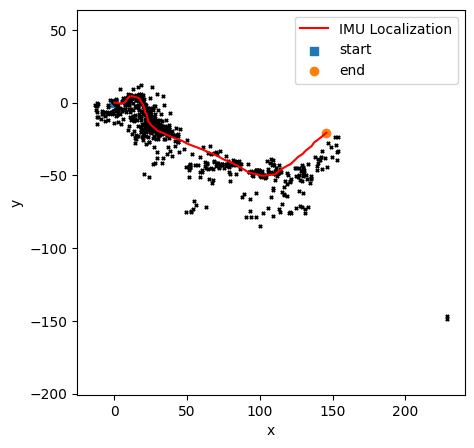

In [36]:
from sklearn.neighbors import NearestNeighbors

# Run the EKF-based landmark mapping
landmarks, landmarks_cov = landmark_mapping_ekf_update(
    poses, dfeatures, K_l, K_r, extL_T_imu, extR_T_imu, 
)
'''max_distance=10
# Remove outliers beyond max_distance
distances = np.linalg.norm(mu, axis=1)
landmarks = landmarks[distances <= max_distance]'''


def remove_outliers_nearest_neighbor(landmarks, n_neighbors=5, threshold=10.0):
    """Remove outliers based on nearest neighbor distance"""
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(landmarks)
    distances, _ = nbrs.kneighbors(landmarks)
    avg_distances = np.mean(distances, axis=1)
    outliers = avg_distances > threshold
    return landmarks[~outliers]

landmarks = remove_outliers_nearest_neighbor(landmarks, n_neighbors=5, threshold=10.0)
visualize_trajectory_2d(poses,landmarks, path_name="IMU Localization", show_ori=False)
plt.show()

  0%|          | 0/3754 [00:00<?, ?it/s]/tmp/ipykernel_17058/2024464988.py:195: RuntimeWarning: invalid value encountered in divide
  Tn = np.nan_to_num(T / rotang)
  1%|▏         | 53/3754 [00:00<00:14, 252.48it/s]/tmp/ipykernel_17058/2024464988.py:195: RuntimeWarning: divide by zero encountered in divide
  Tn = np.nan_to_num(T / rotang)
100%|██████████| 3754/3754 [00:50<00:00, 74.02it/s] 


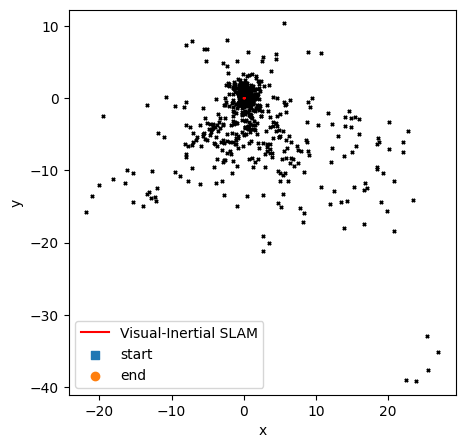

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix, block_diag
from scipy import linalg
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors

# Load data
filename = "data/dataset00/dataset00.npy"
v_t, w_t, timestamps, features, K_l, K_r, extL_T_imu, extR_T_imu = load_data(filename)

# Downsample features to reduce computational load
def downsample_features(features, step=5):
    """Keep every nth feature to reduce computation"""
    return features[:, ::step, :]

dfeatures = downsample_features(features)
num_features = dfeatures.shape[1]
num_timesteps = dfeatures.shape[2]

# Initialize state vector and covariance
state_dim = 6 + 3 * num_features  # 6 for pose, 3*M for landmarks
state = np.zeros(state_dim)  # State vector: [pose (6), landmarks (3*M)]
state[6:] = np.nan  # Initialize landmarks as NaN
cov = np.eye(state_dim) * 1e-4  # Covariance matrix

# Process noise (tune these based on sensor characteristics)
Q_pose = np.eye(6) * 1e-4  # Process noise for pose
Q_landmark = np.eye(3 * num_features) * 1e-4  # Process noise for landmarks
R = np.eye(4) * 1e-2  # Observation noise

# Stereo baseline
b = np.linalg.norm(extR_T_imu[:3, 3] - extL_T_imu[:3, 3])

# Initialize poses array for plotting
poses = np.zeros((num_timesteps, 4, 4))  # SE(3) poses
poses[0] = np.eye(4)  # Initial pose (identity matrix)

# Main SLAM loop
for t in tqdm(range(1, num_timesteps)):
    # IMU Prediction Step
    dt = timestamps[t] - timestamps[t - 1]  # Time difference

    # Current pose and covariance
    pose = state[:6]
    P_prev = cov[:6, :6]

    # IMU measurements (linear and angular velocity)
    v = v_t[t - 1]
    w = w_t[t - 1]

    # SE(3) kinematics: T_{t+1} = T_t * exp(dt * twist)
    twist = np.zeros((4, 4))
    twist[:3, :3] = axangle2skew(w)  # Angular velocity (skew-symmetric matrix)
    twist[:3, 3] = v  # Linear velocity
    T_next = linalg.expm(twist * dt)

    # Jacobian of the motion model (F_t)
    F_t = np.eye(6)  # Simplified Jacobian (identity for small dt)
    F_t[:3, 3:] = axangle2skew(v) * dt  # Update for linear velocity

    # Covariance prediction: P_{t+1} = F_t P_t F_t^T + Q
    P_next = F_t @ P_prev @ F_t.T + Q_pose

    # Update state and covariance
    state[:6] = twist2axangle(T_next)
    cov[:6, :6] = P_next

    # Store the predicted pose for plotting
    poses[t] = T_next

    # Landmark Update Step
    visible = [j for j in range(num_features) if not np.all(dfeatures[:, j, t] == -1)]  # Visible features

    for j in visible:
        z = dfeatures[:, j, t]  # Current observation [ul, vl, ur, vr]

        if np.isnan(state[6 + 3 * j:6 + 3 * (j + 1)]).any():
            # Initialize landmark using stereo triangulation
            state[6 + 3 * j:6 + 3 * (j + 1)] = stereo_triangulation(z, K_l, b, extL_T_imu, T_next)
        else:
            # Update existing landmark using EKF
            m = state[6 + 3 * j:6 + 3 * (j + 1)]  # Current landmark estimate
            m_hom = np.append(m, 1)  # Homogeneous coordinates

            # Left camera projection
            cam_left = extL_T_imu @ np.linalg.inv(T_next) @ m_hom
            z_left = K_l @ (cam_left[:3] / cam_left[2])

            # Right camera projection
            cam_right = extR_T_imu @ np.linalg.inv(T_next) @ m_hom
            z_right = K_r @ (cam_right[:3] / cam_right[2])

            # Predicted observation [ul, vl, ur, vr]
            z_pred = np.concatenate([z_left[:2], z_right[:2]])

            # Compute Jacobian
            J_left = (K_l[:2, :3] @  # Use full intrinsic matrix (2x3)
                      np.linalg.inv(T_next)[:3, :3] @  # Rotation from world to camera frame (3x3)
                      (np.eye(3) - np.outer(cam_left[:3], [0, 0, 1]) / cam_left[2]))  # Projection Jacobian (3x3)

            J_right = (K_r[:2, :3] @  # Use full intrinsic matrix (2x3)
                       np.linalg.inv(T_next)[:3, :3] @  # Rotation from world to camera frame (3x3)
                       (np.eye(3) - np.outer(cam_right[:3], [0, 0, 1]) / cam_right[2]))  # Projection Jacobian (3x3)

            H = np.vstack([J_left, J_right])

            # Kalman gain calculation
            P = cov[6 + 3 * j:6 + 3 * (j + 1), 6 + 3 * j:6 + 3 * (j + 1)]
            S = H @ P @ H.T + R
            K = P @ H.T @ np.linalg.inv(S)

            # Update estimate
            innovation = z[:4] - z_pred
            state[6 + 3 * j:6 + 3 * (j + 1)] += K @ innovation

            # Update covariance (Joseph form for stability)
            I_KH = np.eye(3) - K @ H
            cov[6 + 3 * j:6 + 3 * (j + 1), 6 + 3 * j:6 + 3 * (j + 1)] = I_KH @ P @ I_KH.T + K @ R @ K.T

    # Update the pose in the poses array with the corrected pose from the state vector
    poses[t] = axangle2pose(state[:6])

# Remove NaN values from landmarks before outlier removal
valid_landmarks = state[6:].reshape(-1, 3)
valid_landmarks = valid_landmarks[~np.isnan(valid_landmarks).any(axis=1)]  # Remove rows with NaN

# Remove outliers using nearest neighbor distance
def remove_outliers_nearest_neighbor(landmarks, n_neighbors=5, threshold=10.0):
    """Remove outliers based on nearest neighbor distance"""
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(landmarks)
    distances, _ = nbrs.kneighbors(landmarks)
    avg_distances = np.mean(distances, axis=1)
    outliers = avg_distances > threshold
    return landmarks[~outliers]

landmarks = remove_outliers_nearest_neighbor(valid_landmarks, n_neighbors=1, threshold=0.0)

# Visualize the trajectory and landmarks
visualize_trajectory_2d(poses, landmarks, path_name="Visual-Inertial SLAM", show_ori=False)
plt.show()


In [40]:
print (poses)

[ 7.13605297e-02 -6.35128036e-06  6.64915489e-02  1.24153884e-04
  4.41232624e-03 -6.18712862e-05]


## RoughWork ##

In [20]:
z0 = features[:, :, 60]  # All features at the first timestep
print("First timestep observations (z0):")
print(z0)

First timestep observations (z0):
[[176.03300476  36.53641129 450.58352661 ...  -1.          -1.
   -1.        ]
 [212.01733398 191.98712158 176.21020508 ...  -1.          -1.
   -1.        ]
 [171.65989685  34.20940399 432.6434021  ...  -1.          -1.
   -1.        ]
 [212.08148193 192.09938049 176.20506287 ...  -1.          -1.
   -1.        ]]


In [21]:
print("Original features shape:", features.shape)
z8 = downsample_features(features, step=2)
print("Downsampled features shape:", z8.shape)
num_features = z8.shape[1]
num_timesteps = z8.shape[2]
mu = np.full((num_features, 3), np.nan)
valid_features = []
b = compute_stereo_baseline(extL_T_imu, extR_T_imu)

print("Number of valid features:", len(valid_features))

Original features shape: (4, 12787, 3601)
Downsampled features shape: (4, 6394, 3601)


NameError: name 'compute_stereo_baseline' is not defined